## Exploring Autoencoder for embedding


In [2]:
import argparse
import math
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import customize_dataloader as cd

import torch.optim as optim
from torchvision import datasets, transforms
import pandas as pd
import os

import seaborn as sns

c:\Anaconda\envs\curationsystem\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.cuda.is_available():
    print("CUDA is available. GPU(s) found.")
    print("CUDA devices:")
    for i in range(torch.cuda.device_count()):
        print(f"  - {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Only CPU is being used.")

CUDA is available. GPU(s) found.
CUDA devices:
  - NVIDIA GeForce RTX 3070 Ti


In [10]:
raw_dataset, train_loader, val_loader, test_loader, classes = cd.get_data_loader("./wikiART224",resize=transforms.Resize((32,32)),normailze = True)
print('training examples: ',len(train_loader))
print('validation examples: ',len(val_loader))
print('testing examples: ', len(test_loader))

training examples:  1019
validation examples:  128
testing examples:  128


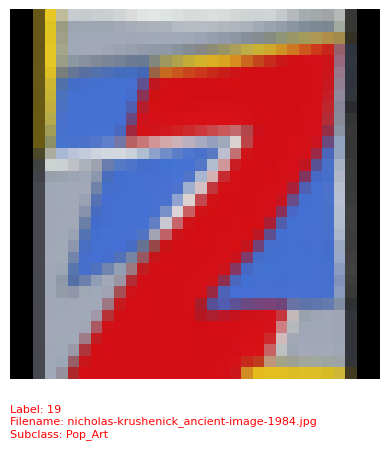

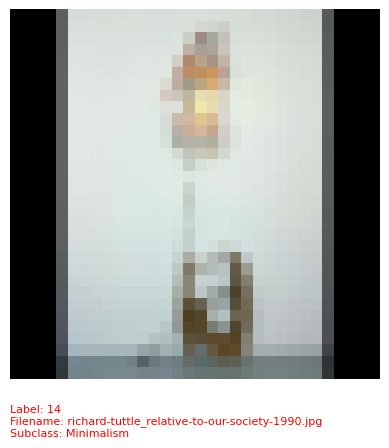

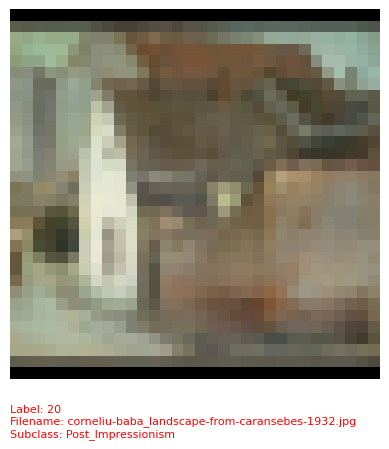

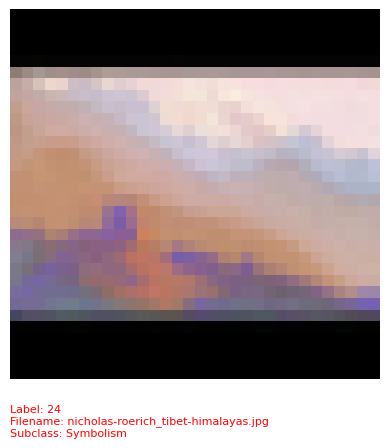

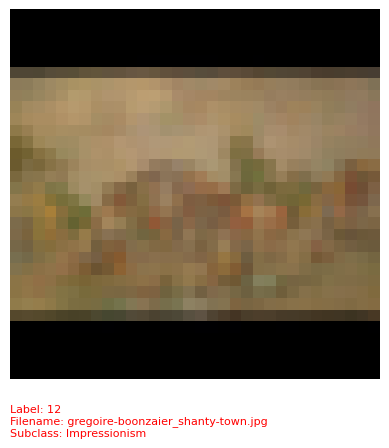

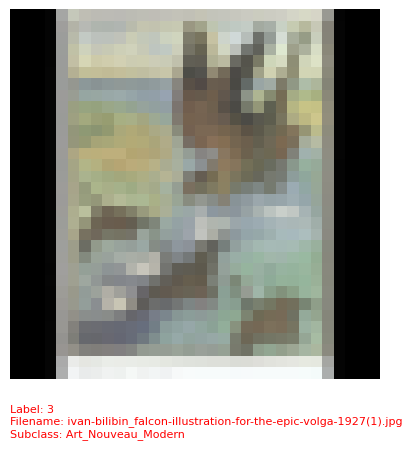

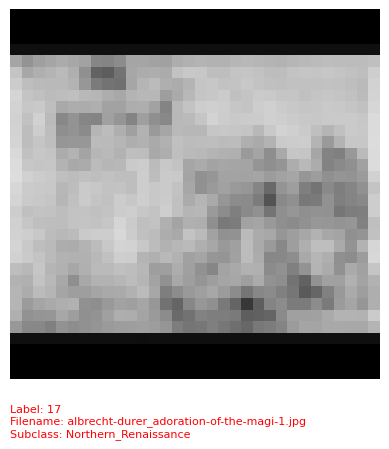

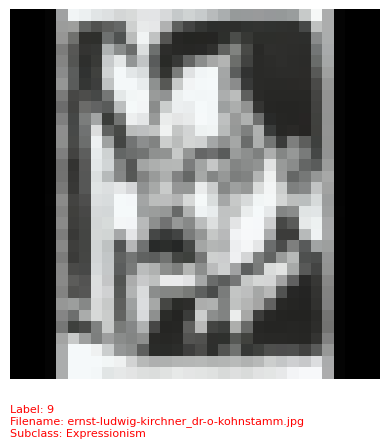

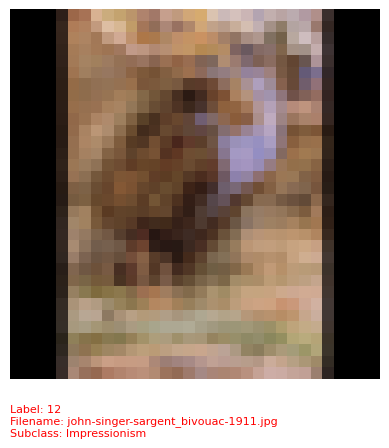

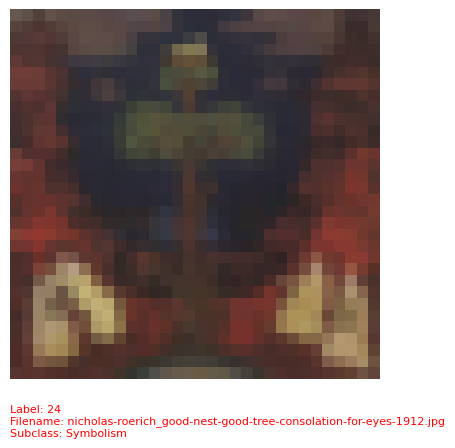

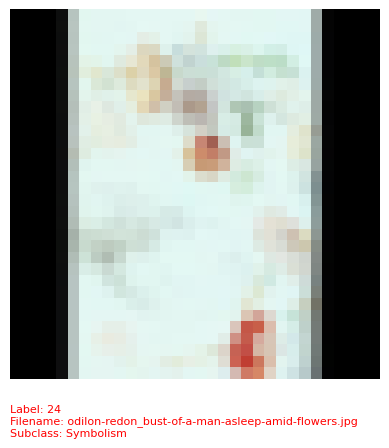

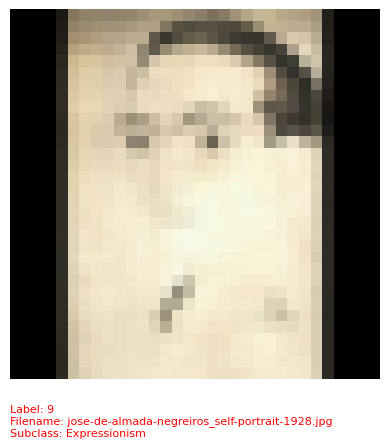

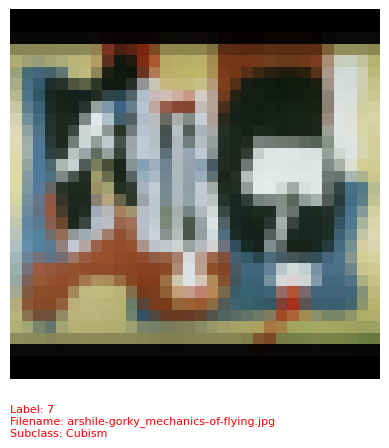

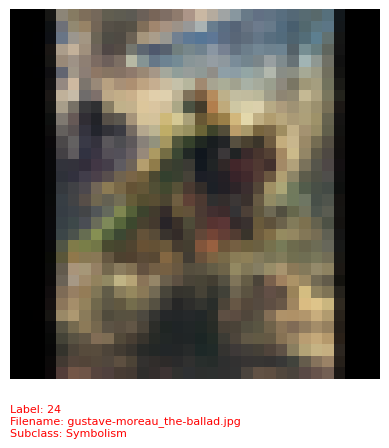

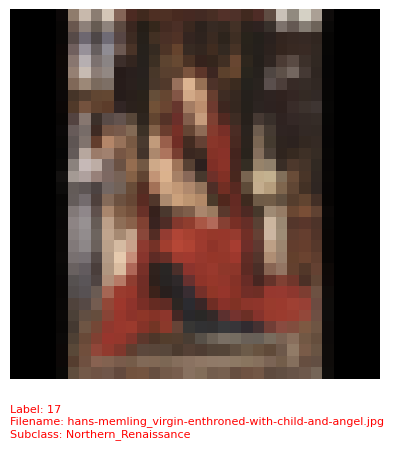

In [11]:
k = 0
# Example iteration over the DataLoader
for images, labels, filenames, sublabels in train_loader:
    # `images` contains a batch of images
    # `labels` contains the corresponding labels
    # `filenames` contains the corresponding filenames
    #
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    label = labels[0]  # Assuming labels are also in batch form
    filename = filenames[0]
    sublabel = sublabels[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1, 2, 0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.imshow(img)
    plt.axis('off')
    text = f"Label: {label}\nFilename: {filename}\nSubclass: {sublabel}"
    plt.text(0, -0.15, text, color='red', fontsize=8, transform=plt.gca().transAxes, wrap=True)  # Adjust text position and size
    plt.show()
    k += 1
    if k > 14:
        break
    pass



## Basic Autoencoder

In [71]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [72]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)# <--
    raw_dataset, train_loader, val_loader, test_loader, classes = cd.get_data_loader("./wikiART224",resize=transforms.Resize((64,64)))

    model.cuda()
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _,_,_ = data
            img = img.cuda()
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

In [73]:
model = Autoencoder()
max_epochs = 50
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.0047
Epoch:2, Loss:0.0023
Epoch:3, Loss:0.0028
Epoch:4, Loss:0.0069
Epoch:5, Loss:0.0029


KeyboardInterrupt: 

## Explore U-Net

### Training 

In [12]:
def visualize(inputs, outputs, use_gpu=False, n=10):
    """
    Visualize the original images, their expected outputs, and the model predictions.

    Args:
      inputs (tensor): The original images.
      targets (tensor): The true outputs (for an autoencoder, this could be the same as inputs).
      outputs (tensor): The model's predictions.
      use_gpu (bool): Flag indicating whether the tensors are on a GPU.
      n (int): Number of samples to visualize.
    """
    if use_gpu:
        inputs = inputs.cpu()
        outputs = outputs.cpu()

    inputs = inputs.numpy()[:n].transpose((0, 2, 3, 1))
    outputs = outputs.detach().numpy()[:n].transpose((0, 2, 3, 1))

    fig, axes = plt.subplots(2, n, figsize=(n*2, 6))
    if n == 1:
        axes = np.expand_dims(axes, 1)  # Make sure axes is 2D array
    
    for i in range(n):
        for ax, img, title in zip(axes[:, i], [inputs[i], outputs[i]], ['Input', 'Output']):
            ax.imshow(np.clip(img, 0, 1))
            ax.set_title(title)
            ax.axis('off')
    plt.tight_layout()
    plt.show()


In [6]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(args, gen=None):

    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE MODEL
    if gen is None:
        Net = globals()[args.model]
        gen = Net(args.kernel, args.num_filters)

    # LOSS FUNCTION
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(gen.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    _, train_loader, _, _, _ = cd.get_data_loader("./wikiART224",batch_size=args.batch_size,resize=args.resize)

    #print("Transforming data...")
    #train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    #test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        gen.cuda()

    for epoch in range(args.epochs):
        # Train the Model
        gen.train()  # Change model to 'train' mode
        losses = []
        for i, data in enumerate(train_loader,0):
            inputs, _,_,_= data

            #############################################
            #To Enable GPU Usage
            if torch.cuda.is_available():
              inputs = inputs.cuda()
            #############################################

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = gen(inputs)

            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        print(epoch, loss.cpu().detach())
        #if epoch%5 == 0 and args.plot:
        visualize(inputs, outputs, args.gpu, 1)
        # Save the model state dictionary
        model_save_path = os.path.join(save_dir, f'model_epoch_{epoch}.pth')
        torch.save(gen.state_dict(), model_save_path)

    return gen

### Testing Unet

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=3):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2

        # Downsampling Path
        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        
        self.downconv3 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        # Bottleneck Path
        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*4, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.ReLU())
        
        # Upsampling Path
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters*2, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),)
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),)
        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*2, num_filters, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),)
        
        self.finalconv = nn.Conv2d(num_filters + num_in_channels, num_colours, kernel_size=kernel, padding=padding)

    def forward(self, x):
        # Downsampling path
        x1 = self.downconv1(x)
        x2 = self.downconv2(x1)
        x3 = self.downconv3(x2)

        # Bottleneck
        x_rf = self.rfconv(x3)

        # Upsampling path with skip connections
        x_up1 = self.upconv1(x_rf)
        x_up1_skip = torch.cat([x_up1, x2], dim=1)  # Skip connection from second to second last
        
        x_up2 = self.upconv2(x_up1_skip)
        x_up2_skip = torch.cat([x_up2, x1], dim=1)  # Skip connection from first to last
        
        x_up3 = self.upconv3(x_up2_skip)
        x_up3_skip = torch.cat([x_up3, x], dim=1)  # Adding original input to the final output before the final convolution
        
        # Final convolution
        out = self.finalconv(x_up3_skip)

        return out

Loading data...
Beginning training ...
0 tensor(0.0050)


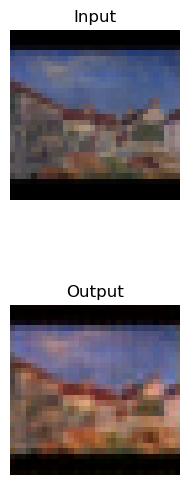

In [37]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001,
    "batch_size": 64,
    "epochs": 1,
    "seed": 0,
    "resize": transforms.Resize((32,32)),
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

Loading data...
Beginning training ...
0 tensor(0.0033)


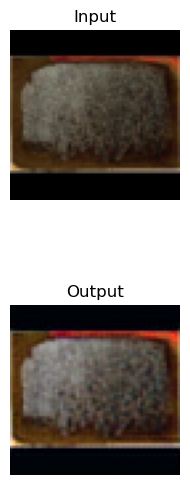

In [38]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 64,
    'learn_rate':0.001,
    "batch_size": 32,
    "epochs": 1,
    "seed": 0,
    "resize": transforms.Resize((64,64)),
    "plot": True,
    "experiment_name": "unet_test",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn_2 = train(args)

### Testing encoder and decoder Unet

In [15]:
class UNetEncoder(nn.Module):
    def __init__(self, kernel, num_filters, num_in_channels=3):
        super(UNetEncoder, self).__init__()
        stride = 2
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.downconv3 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*4, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.ReLU())

    def forward(self, x):
        x1 = self.downconv1(x)
        x2 = self.downconv2(x1)
        x3 = self.downconv3(x2)
        x_rf = self.rfconv(x3)
        return x1, x2, x3, x_rf


In [16]:
class UNetDecoder(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=3):
        super(UNetDecoder, self).__init__()
        padding = kernel // 2

        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters*2, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*2, num_filters, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())

        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(num_filters, num_filters, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())

        self.finalconv = nn.Conv2d(num_filters, num_colours, kernel_size=kernel, padding=padding)

    def forward(self, x1, x2, x3, x_rf, original_x):
        x_up1 = self.upconv1(x_rf)
        x_up1_skip = torch.cat([x_up1, x2], dim=1)
        
        x_up2 = self.upconv2(x_up1_skip)
        #x_up2_skip = torch.cat([x_up2, x1], dim=1)
        
        x_up3 = self.upconv3(x_up2)
        #x_up3_skip = torch.cat([x_up3, original_x], dim=1)
        
        out = self.finalconv(x_up3)
        return out


In [17]:
class UNet_parts(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=3):
        super(UNet_parts, self).__init__()
        self.encoder = UNetEncoder(kernel, num_filters, num_in_channels)
        self.decoder = UNetDecoder(kernel, num_filters, num_colours, num_in_channels)

    def forward(self, x):
        x1, x2, x3, x_rf = self.encoder(x)
        out = self.decoder(x1, x2, x3, x_rf, x)
        return out


Loading data...
Beginning training ...
0 tensor(0.0005)


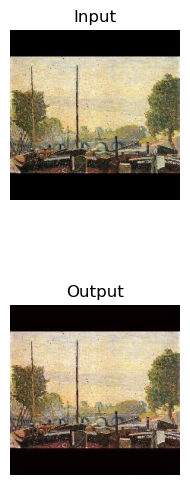

1 tensor(0.0006)
2 tensor(0.0001)
3 tensor(0.0001)
4 tensor(1.1828e-05)
5 tensor(1.2201e-05)


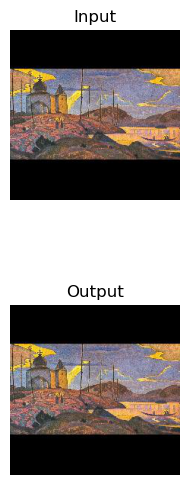

6 tensor(3.3652e-06)
7 tensor(7.4625e-06)
8 tensor(2.9460e-05)
9 tensor(4.1209e-06)


In [101]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "model": "UNet_encoder",
    "kernel": 3,
    "num_filters": 64,
    'learn_rate':0.001,
    "batch_size": 32,
    "epochs": 10,
    "seed": 0,
    "resize": transforms.Resize((224,224)),
    "plot": True,
    "experiment_name": "unet_test",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
unet_enc = train(args)

Visualize method


In [20]:
raw_dataset, train_loader, val_loader, test_loader, classes = cd.get_data_loader("./wikiART224",resize=transforms.Resize((224,224)),normailze = True)
print('training examples: ',len(train_loader))
print('validation examples: ',len(val_loader))
print('testing examples: ', len(test_loader))

training examples:  1019
validation examples:  128
testing examples:  128


In [31]:
def visualize_reconstructions(model, data_loader, num_images=5):
    """
    Visualizes original and regenerated images using the given model and data from a DataLoader.
    
    Parameters:
    - model: The PyTorch model to use for image regeneration.
    - data_loader: DataLoader containing the dataset for visualization.
    - num_images: The number of images to visualize.
    """
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Inference without gradient calculation
        for batch in data_loader:
            original_images, _, _, _ = batch  # Adjust if your DataLoader structure is different
            
            # Move data to GPU if available
            if torch.cuda.is_available():
                original_images = original_images.cuda()
            
            # Regenerate images
            regenerated_images = model(original_images).cpu()
            
            original_images = original_images.cpu()
            
            # Visualization loop
            fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
            for i in range(num_images):
                # Original Image
                original_img_np = original_images[i].permute(1, 2, 0).numpy()
                axes[0, i].imshow(original_img_np)
                axes[0, i].set_title(f'Original {i+1}')
                axes[0, i].axis('off')

                # Regenerated Image
                regenerated_img_np = regenerated_images[i].permute(1, 2, 0).numpy()
                axes[1, i].imshow(regenerated_img_np)
                axes[1, i].set_title(f'Regenerated {i+1}')
                axes[1, i].axis('off')

            plt.show()
            
            # Break after visualizing the first batch of the specified number of images
            break


In [32]:
class UNetEncoder(nn.Module):
    def __init__(self, kernel, num_filters, num_in_channels=3):
        super(UNetEncoder, self).__init__()
        stride = 2
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.downconv3 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*4, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.ReLU())

    def forward(self, x):
        x1 = self.downconv1(x)
        x2 = self.downconv2(x1)
        x3 = self.downconv3(x2)
        x_rf = self.rfconv(x3)
        return x1, x2, x3, x_rf


In [33]:
class UNetDecoder_simp(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=3):
        super(UNetDecoder, self).__init__()
        padding = kernel // 2

        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters*2, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*2, num_filters, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())

        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(num_filters, num_filters, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())

        self.finalconv = nn.Conv2d(num_filters, num_colours, kernel_size=kernel, padding=padding)

    def forward(self, x1, x2, x3, x_rf, original_x):
        x_up1 = self.upconv1(x_rf)
        x_up1_skip = torch.cat([x_up1, x2], dim=1)
        
        x_up2 = self.upconv2(x_up1_skip)
        #x_up2_skip = torch.cat([x_up2, x1], dim=1)
        
        x_up3 = self.upconv3(x_up2)
        #x_up3_skip = torch.cat([x_up3, original_x], dim=1)
        
        out = self.finalconv(x_up3)
        return out


In [34]:
class UNet_simp(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=3):
        super(UNet_simp, self).__init__()
        self.encoder = UNetEncoder(kernel, num_filters, num_in_channels)
        self.decoder = UNetDecoder(kernel, num_filters, num_colours, num_in_channels)

    def forward(self, x):
        x1, x2, x3, x_rf = self.encoder(x)
        out = self.decoder(x1, x2, x3, x_rf, x)
        return out


Loading data...
Beginning training ...
0 tensor(0.0035)


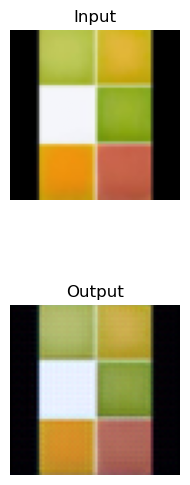

1 tensor(0.0001)


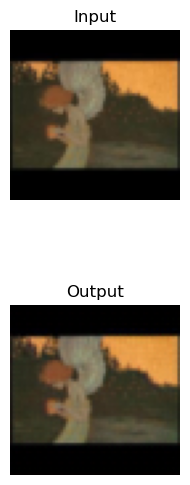

2 tensor(9.8871e-05)


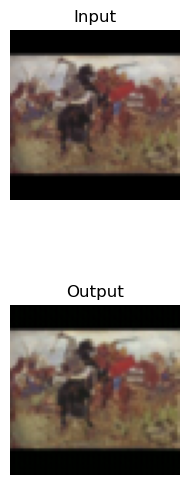

In [36]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "model": "UNet_simp",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001,
    "batch_size": 32,
    "epochs": 3,
    "seed": 0,
    "resize": transforms.Resize((64,64)),
    "plot": True,
    "experiment_name": "UNet_simp_test",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
unet_enc = train(args)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

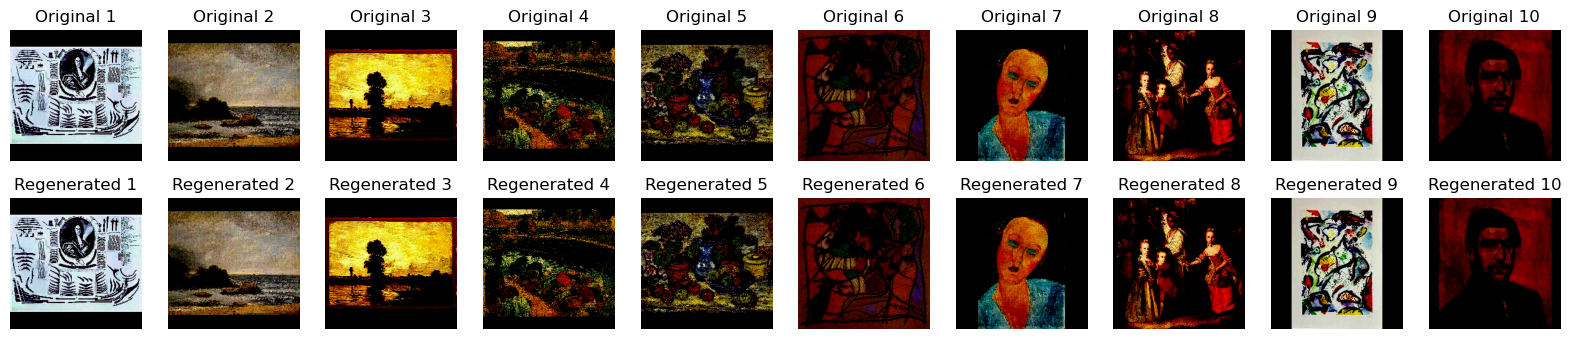

In [36]:
# Assuming 'model' is your loaded model and 'val_loader' is your validation DataLoader
visualize_reconstructions(model, val_loader, num_images=10)


### Save Embeddings

Load large model

In [14]:
# large
model_large = UNet_parts(kernel=3, num_filters=64, num_colours=3, num_in_channels=3)

NameError: name 'UNet_parts' is not defined

In [10]:
# Ensure you're loading the model on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the state dictionary
model_state_dict = torch.load('./outputs/unet_test/model_epoch_9.pth', map_location=device)

In [11]:
# Update the model with the loaded state dictionary
model_large.load_state_dict(model_state_dict)

# Switch the model to evaluation mode
#model.eval()

<All keys matched successfully>

In [12]:
raw_dataset, train_loader, val_loader, test_loader, classes = cd.get_data_loader("./wikiART224",resize=transforms.Resize((224,224)),normailze = True)
print('training examples: ',len(train_loader))
print('validation examples: ',len(val_loader))
print('testing examples: ', len(test_loader))

training examples:  1019
validation examples:  128
testing examples:  128


In [13]:
encoded_features = []
labels_list = []

for i, data in enumerate(val_loader, 0):
    inputs, labels, _, _ = data
    
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        model = model.cuda()
        
    with torch.no_grad():  # Ensuring no gradients are computed
        outputs = model.encoder(inputs)
        
    # Assuming you want to use the bottleneck features, which is the last in the tuple
    vec = outputs[-1]  # This selects the last tensor from the tuple
    
    # Flatten the selected tensor to 1D and move it to CPU
    vec = vec.view(vec.size(0), -1).cpu().numpy()
    
    # Collect the flattened features and labels
    for v, l in zip(vec, labels.numpy()):
        encoded_features.append(v)
        labels_list.append(l)


In [14]:
# Create DataFrame
df = pd.DataFrame({
    'Encoded Features': encoded_features,
    'Labels': labels_list
})

# Saving the DataFrame to a CSV will not work as expected due to the array data in 'Encoded Features'.
# You might consider saving with a different format or processing the data differently for storage.


In [15]:
df.head()


,Encoded Features,Labels
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
1,"[0.0, 0.16620643, 0.024243653, 0.024243653, 0....",23
2,"[0.0, 0.16620643, 0.024243653, 0.024243653, 0....",26
3,"[0.0, 0.2034401, 0.06786728, 0.07378559, 0.077...",24
4,"[0.0, 0.16620643, 0.024243653, 0.024243653, 0....",24


Save encoded Features

In [17]:
import pickle
# Save the data using pickle
with open('./outputs/encoded_features_and_labels_VAE_224.pkl', 'wb') as f:
    pickle.dump(df, f)

In [19]:
with open('./outputs/encoded_features_and_labels_VAE_224.pkl', 'rb') as f:
    data_loaded = pickle.load(f)
encoded_features_loaded = data_loaded['Encoded Features']
labels_loaded = data_loaded['Labels']
df = pd.DataFrame({
    'Encoded Features': encoded_features,
    'Labels': labels_list
})
df.head()

,Encoded Features,Labels
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
1,"[0.0, 0.16620643, 0.024243653, 0.024243653, 0....",23
2,"[0.0, 0.16620643, 0.024243653, 0.024243653, 0....",26
3,"[0.0, 0.2034401, 0.06786728, 0.07378559, 0.077...",24
4,"[0.0, 0.16620643, 0.024243653, 0.024243653, 0....",24


In [20]:
df.Labels.unique()


array([ 3, 23, 26, 24, 21, 15, 20,  9, 12,  8, 19, 14, 22, 13,  0,  7, 11,
        5,  4, 17, 10,  6, 16, 25,  1, 18,  2], dtype=int64)

## Clustering

In [21]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Assuming 'df' is your DataFrame and it contains 'Encoded Features' and 'Labels'
features = np.stack(df['Encoded Features'].values)  # Convert list of arrays into a single numpy array

# Dimensionality Reduction with PCA
pca = PCA(n_components=50)  # Adjust n_components based on your dataset and needs
features_reduced = pca.fit_transform(features)


In [22]:
# Perform K-means clustering
k = 27  # Number of clusters; adjust based on your needs or use methods like the Elbow method to decide
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(features_reduced)


c:\Anaconda\envs\curationsystem\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [23]:
# Add the cluster labels to your DataFrame
df['Cluster Labels'] = cluster_labels

# Analyze the distribution of original labels within each cluster
cluster_label_distribution = df.groupby('Cluster Labels')['Labels'].value_counts().unstack().fillna(0)

print(cluster_label_distribution)


Labels            0    1    2     3      4     5    6     7     8      9   \
Cluster Labels                                                              
0                1.0  0.0  0.0   0.0    0.0   2.0  0.0   0.0   0.0    2.0   
1               20.0  0.0  4.0  34.0   78.0   8.0  7.0  18.0  11.0   79.0   
2                0.0  0.0  0.0   1.0    0.0   2.0  0.0   3.0   0.0    3.0   
3               32.0  1.0  0.0  23.0   10.0  19.0  1.0  10.0   2.0   33.0   
4                1.0  0.0  0.0   0.0    0.0   3.0  0.0   1.0   0.0    1.0   
5               22.0  1.0  0.0  31.0   28.0  12.0  7.0  17.0   7.0   54.0   
6                1.0  0.0  0.0   1.0    1.0   1.0  1.0   2.0   0.0    7.0   
7                0.0  0.0  0.0   0.0    0.0   0.0  1.0   1.0   0.0    2.0   
8                1.0  0.0  0.0   0.0    0.0   1.0  0.0   0.0   0.0    0.0   
9                5.0  0.0  0.0   2.0    0.0   8.0  0.0   3.0   0.0    9.0   
10               3.0  0.0  0.0   1.0    0.0   8.0  2.0   0.0   0.0    2.0   

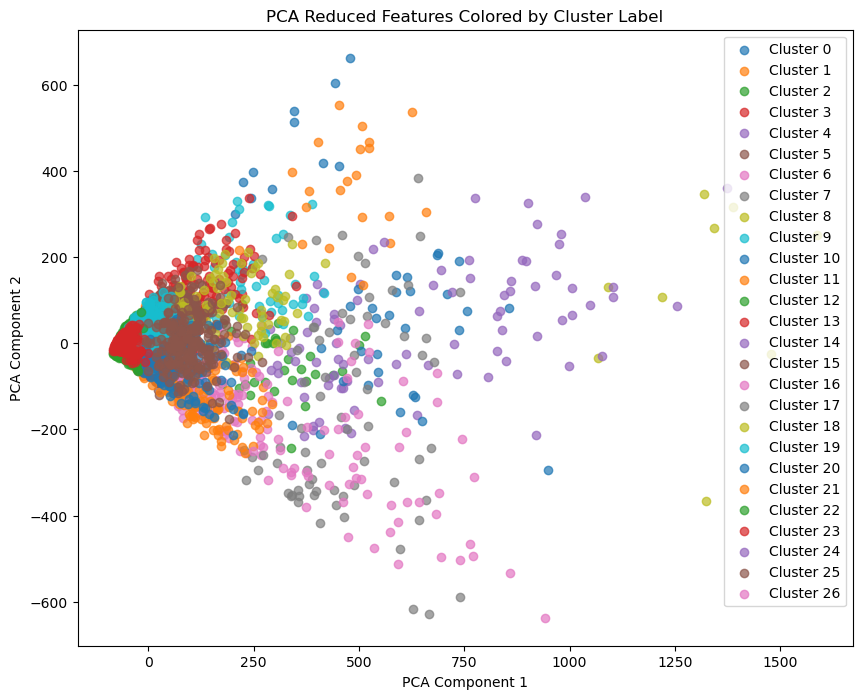

In [25]:
# Assuming 'features_reduced' contains your PCA-reduced features and 'cluster_labels' are your cluster assignments

plt.figure(figsize=(10, 8))

# Scatter plot of the first two PCA components, colored by cluster label
for i in range(k):  # 'k' is the number of clusters
    plt.scatter(features_reduced[cluster_labels == i, 0], features_reduced[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.7)

plt.title('PCA Reduced Features Colored by Cluster Label')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


PCA scatter plot where each point is colored by its cluster label and annotated or indicated by its original label

In [26]:
# Add PCA components to the DataFrame for easier plotting
df['PCA1'] = features_reduced[:, 0]
df['PCA2'] = features_reduced[:, 1]


In [27]:
# Assuming 'df' is your DataFrame, which now includes a 'Cluster Labels' column from your clustering results
cluster_label_counts = df.groupby('Cluster Labels')['Labels'].value_counts().unstack(fill_value=0)

print(cluster_label_counts)


Labels          0   1   2   3    4   5   6   7   8    9   ...  17  18  19  \
Cluster Labels                                            ...               
0                1   0   0   0    0   2   0   0   0    2  ...   0   1   0   
1               20   0   4  34   78   8   7  18  11   79  ...  25   5   3   
2                0   0   0   1    0   2   0   3   0    3  ...   1   0   3   
3               32   1   0  23   10  19   1  10   2   33  ...  14   6  18   
4                1   0   0   0    0   3   0   1   0    1  ...   0   0   2   
5               22   1   0  31   28  12   7  17   7   54  ...  12   5  10   
6                1   0   0   1    1   1   1   2   0    7  ...   1   1   1   
7                0   0   0   0    0   0   1   1   0    2  ...   0   1   2   
8                1   0   0   0    0   1   0   0   0    0  ...   0   0   1   
9                5   0   0   2    0   8   0   3   0    9  ...   0   0   1   
10               3   0   0   1    0   8   2   0   0    2  ...   0   1   5   

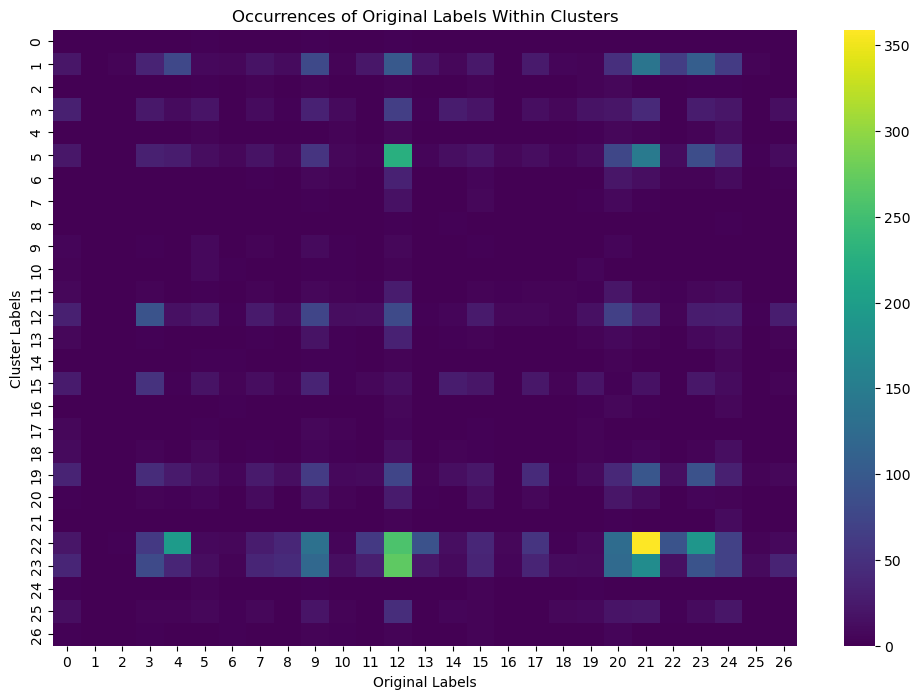

In [28]:
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_label_counts, annot=False, cmap='viridis', fmt='g')
plt.title('Occurrences of Original Labels Within Clusters')
plt.xlabel('Original Labels')
plt.ylabel('Cluster Labels')
plt.show()
